# Gradient Descent Classification for Predicting Political Interest

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(42)

# # Display settings
# pd.set_option('display.max_columns', None)
# plt.style.use('seaborn-whitegrid')
# %matplotlib inline

## Loading and Exploring the Dataset

In [3]:
print("Loading the dataset... (this may take some time)")
file_path = "WVS_Time_Series_1981-2022_csv_v5_0.csv"

# Using chunksize to handle large file
chunks = pd.read_csv(file_path, chunksize=10000)

# Extract only the columns we need to save memory
columns_of_interest = ['E023', 'A006', 'A001', 'X025R', 'X003']
df_list = []

for chunk in chunks:
    # Keep only columns we're interested in
    df_list.append(chunk[columns_of_interest])

# Combine all chunks
df = pd.concat(df_list, ignore_index=True)
print(f"Dataset loaded with shape: {df.shape}")

Loading the dataset... (this may take some time)
Dataset loaded with shape: (443488, 5)


In [4]:
# Display basic information
print("\nBasic information about the dataset:")
print(df.info())

# Check unique values in each column
print("\nUnique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].unique()}")


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443488 entries, 0 to 443487
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   E023    443488 non-null  int64
 1   A006    443488 non-null  int64
 2   A001    443488 non-null  int64
 3   X025R   443488 non-null  int64
 4   X003    443488 non-null  int64
dtypes: int64(5)
memory usage: 16.9 MB
None

Unique values in each column:
E023: [ 4  3  2  1 -1 -2 -4 -5]
A006: [ 2  1  3  4 -1 -2 -4 -5]
A001: [ 1  2 -1  4  3 -4 -2 -5]
X025R: [ 2  1  3 -2 -4 -1 -5]
X003: [ 18  24  26  30  38  35  41  55  66  20  19  28  34  44  46  56  65  21
  22  32  59  67  17  54  64  80  40  42  50  60  78  43  45  74  23  68
  48  63  75  33  39  47  49  25  57  52  31  36  51  62  76  29  61  27
  37  58  53  69  70  77  -2  72  71  73  79  81  88  84  86  83  90  85
  87  82  16  89  91  92  93  14  15  94  95  98  -5  99  97  -1  96  -4
 102  13 100 103  -3]


## Data Cleaning and Preprocessing

In [5]:
print("\nCleaning the dataset...")

# Define a function to clean the data by removing invalid codes
def clean_column(series):
    # Replace invalid codes with NaN
    return series.replace([-1, -2, -4, -5], np.nan)

# Apply cleaning to all columns
for col in df.columns:
    df[col] = clean_column(df[col])

# Drop rows with missing values
df_cleaned = df.dropna()
print(f"Shape after cleaning: {df_cleaned.shape}")


Cleaning the dataset...
Shape after cleaning: (391305, 5)


In [6]:
# Feature engineering
print("\nPreparing features and target...")

# For political interest (E023), we'll convert it to binary:
# 1 & 2 (Very/Rather important) -> 1 (High interest)
# 3 & 4 (Not very/Not at all important) -> 0 (Low interest)
df_cleaned['politics_binary'] = df_cleaned['E023'].map(lambda x: 1 if x <= 2 else 0)

# Create feature matrix X and target vector y
X = df_cleaned[['A006', 'A001', 'X025R', 'X003']]
y = df_cleaned['politics_binary']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Preparing features and target...
Training data shape: (313044, 4)
Testing data shape: (78261, 4)


C:\Users\mar19\AppData\Local\Temp\ipykernel_25344\853469784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['politics_binary'] = df_cleaned['E023'].map(lambda x: 1 if x <= 2 else 0)


## Data Visualization

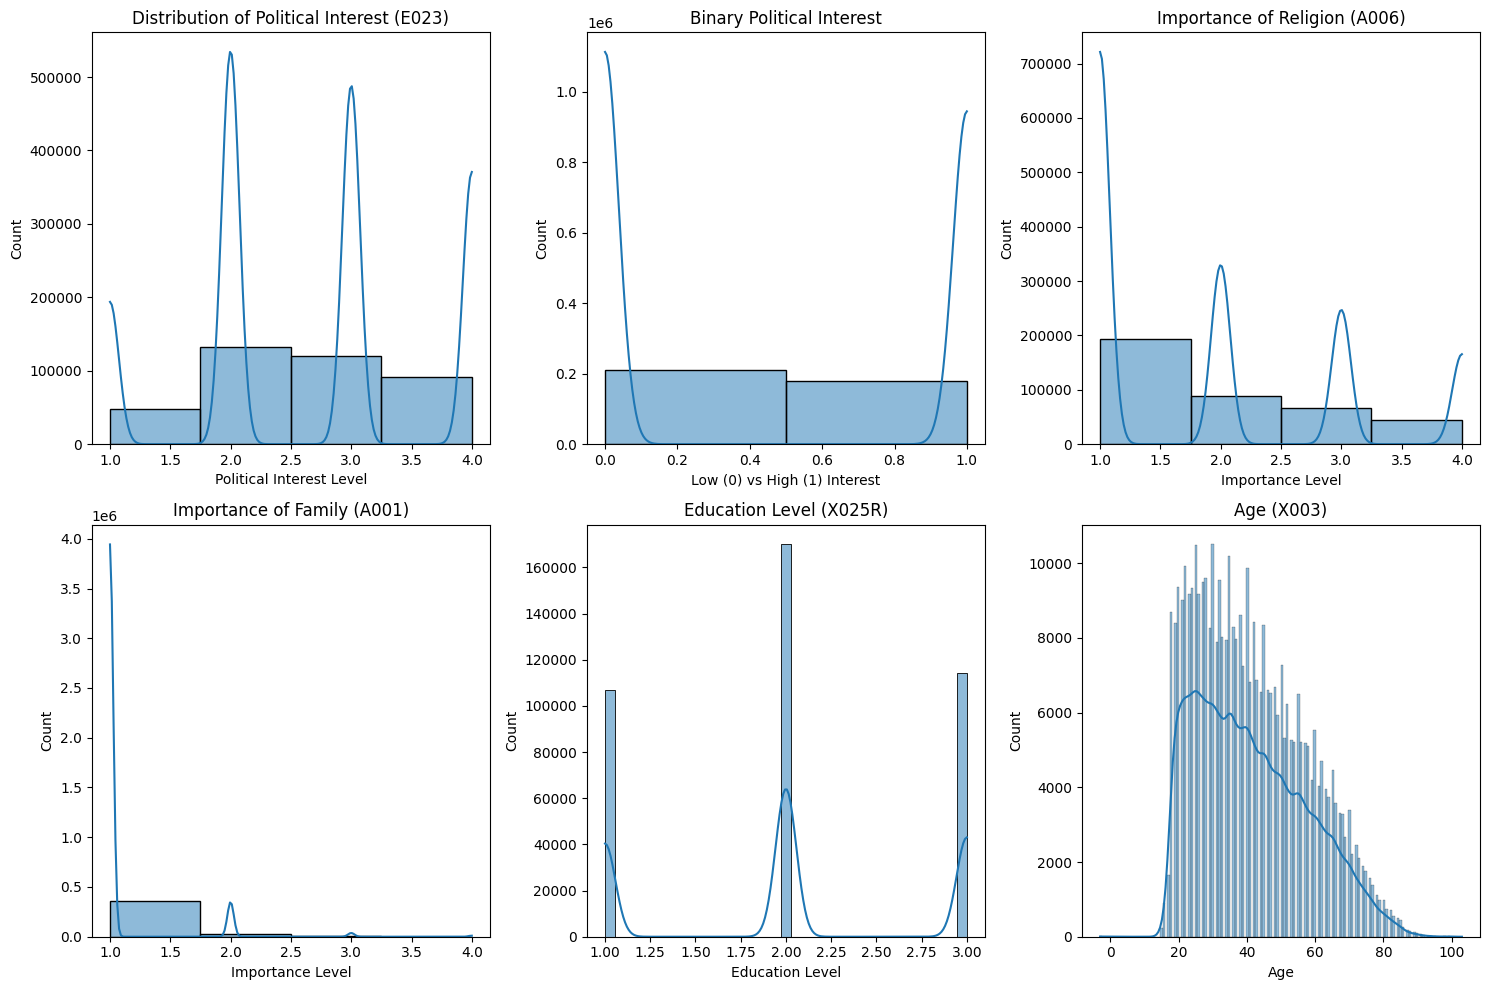

In [7]:
# Visualize the distribution of features and target
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(df_cleaned['E023'], bins=4, kde=True)
plt.title('Distribution of Political Interest (E023)')
plt.xlabel('Political Interest Level')

plt.subplot(2, 3, 2)
sns.histplot(df_cleaned['politics_binary'], bins=2, kde=True)
plt.title('Binary Political Interest')
plt.xlabel('Low (0) vs High (1) Interest')

plt.subplot(2, 3, 3)
sns.histplot(df_cleaned['A006'], bins=4, kde=True)
plt.title('Importance of Religion (A006)')
plt.xlabel('Importance Level')

plt.subplot(2, 3, 4)
sns.histplot(df_cleaned['A001'], bins=4, kde=True)
plt.title('Importance of Family (A001)')
plt.xlabel('Importance Level')

plt.subplot(2, 3, 5)
sns.histplot(df_cleaned['X025R'], kde=True)
plt.title('Education Level (X025R)')
plt.xlabel('Education Level')

plt.subplot(2, 3, 6)
sns.histplot(df_cleaned['X003'], kde=True)
plt.title('Age (X003)')
plt.xlabel('Age')

plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

## Implementing Gradient Descent for Logistic Regression

In [8]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta, lambda_param=0):
    """
    Compute cost function for logistic regression
    
    Args:
        X: Features matrix
        y: Target vector
        theta: Parameters vector
        lambda_param: Regularization parameter
    
    Returns:
        J: Cost value
    """
    m = len(y)
    h = sigmoid(X @ theta)
    
    # Handle potential numerical issues
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    # Cross-entropy loss
    J = -1/m * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    
    # Add regularization (excluding the bias term)
    if lambda_param > 0:
        J += (lambda_param / (2 * m)) * np.sum(np.square(theta[1:]))
    
    return J

def compute_gradient(X, y, theta, lambda_param=0):
    """
    Compute the gradient for logistic regression
    
    Args:
        X: Features matrix
        y: Target vector
        theta: Parameters vector
        lambda_param: Regularization parameter
    
    Returns:
        grad: Gradient vector
    """
    m = len(y)
    h = sigmoid(X @ theta)
    
    # Basic gradient
    grad = 1/m * (X.T @ (h - y))
    
    # Add regularization (excluding the bias term)
    if lambda_param > 0:
        grad[1:] += (lambda_param / m) * theta[1:]
    
    return grad

def gradient_descent(X, y, theta, alpha, num_iters, lambda_param=0):
    """
    Perform gradient descent to optimize theta
    
    Args:
        X: Features matrix
        y: Target vector
        theta: Initial parameters
        alpha: Learning rate
        num_iters: Number of iterations
        lambda_param: Regularization parameter
    
    Returns:
        theta: Optimized parameters
        J_history: Cost history
    """
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        # Compute gradient
        grad = compute_gradient(X, y, theta, lambda_param)
        
        # Update parameters
        theta = theta - alpha * grad
        
        # Compute and store cost
        cost = compute_cost(X, y, theta, lambda_param)
        J_history.append(cost)
        
        # Print progress
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost}")
    
    return theta, J_history

## Model Training

In [9]:
# Add a column of ones to X for the bias term
X_train_with_bias = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]

# Initialize parameters
initial_theta = np.zeros(X_train_with_bias.shape[1])

# Set hyperparameters
alpha = 0.01  # Learning rate
num_iters = 1000  # Number of iterations
lambda_param = 0.1  # Regularization parameter

print("\nTraining logistic regression with gradient descent...")
# Train model
theta, J_history = gradient_descent(X_train_with_bias, y_train, initial_theta, alpha, num_iters, lambda_param)


Training logistic regression with gradient descent...
Iteration 0: Cost = 0.6930845151431819
Iteration 100: Cost = 0.6880606146540958
Iteration 200: Cost = 0.6848533363161153
Iteration 300: Cost = 0.6827856311720082
Iteration 400: Cost = 0.6814393022815348
Iteration 500: Cost = 0.6805543190964226
Iteration 600: Cost = 0.6799674517837545
Iteration 700: Cost = 0.6795751442170234
Iteration 800: Cost = 0.6793109917298765
Iteration 900: Cost = 0.6791319722080309


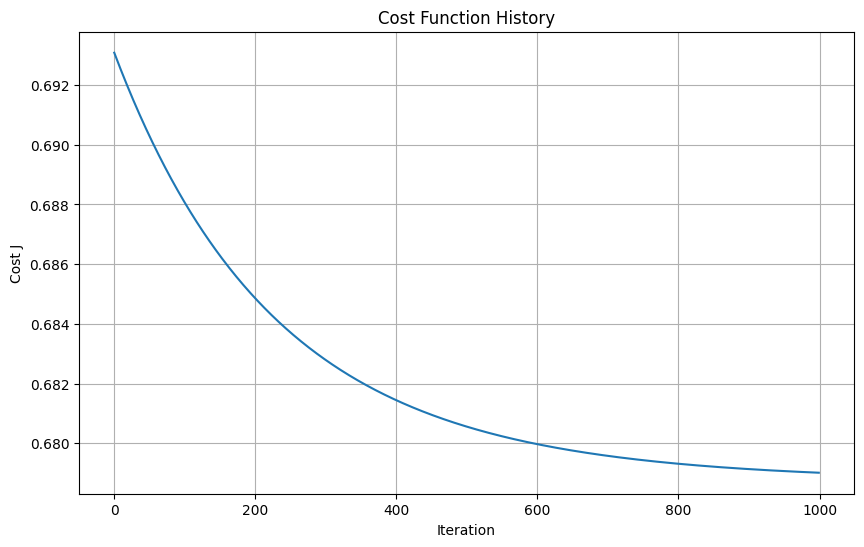

In [10]:
# Plot cost history
plt.figure(figsize=(10, 6))
plt.plot(J_history)
plt.xlabel('Iteration')
plt.ylabel('Cost J')
plt.title('Cost Function History')
plt.grid(True)
plt.savefig('cost_history.png')
plt.show()

## Model Evaluation

In [11]:
# Make predictions
y_train_pred_prob = sigmoid(X_train_with_bias @ theta)
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)

y_test_pred_prob = sigmoid(X_test_with_bias @ theta)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nModel evaluation:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")


Model evaluation:
Training accuracy: 0.5750
Testing accuracy: 0.5750


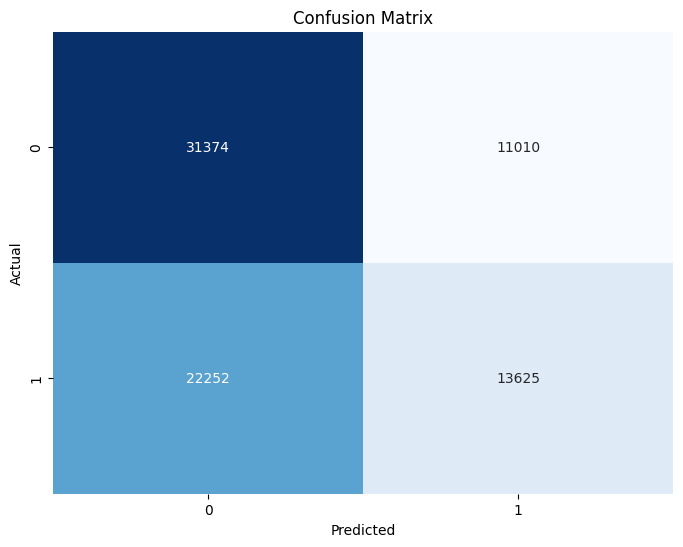


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.74      0.65     42384
           1       0.55      0.38      0.45     35877

    accuracy                           0.57     78261
   macro avg       0.57      0.56      0.55     78261
weighted avg       0.57      0.57      0.56     78261



In [12]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

## Feature Importance Analysis

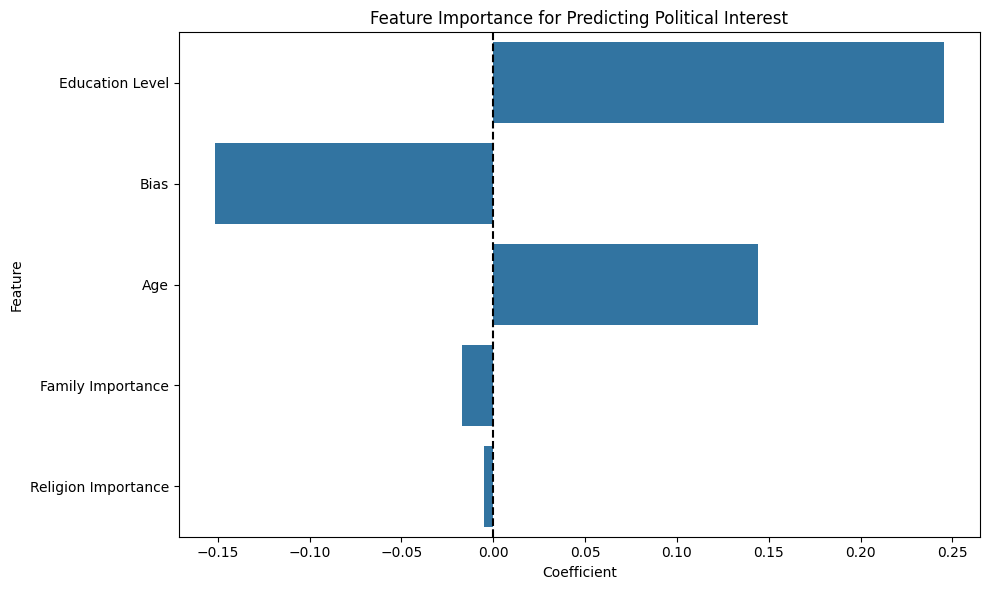

In [13]:
# Feature importance analysis
feature_names = ['Bias', 'Religion Importance', 'Family Importance', 'Education Level', 'Age']
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': theta
})

# Sort by absolute coefficient value
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance for Predicting Political Interest')
plt.axvline(x=0, color='k', linestyle='--')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

## Feature Effects Visualization

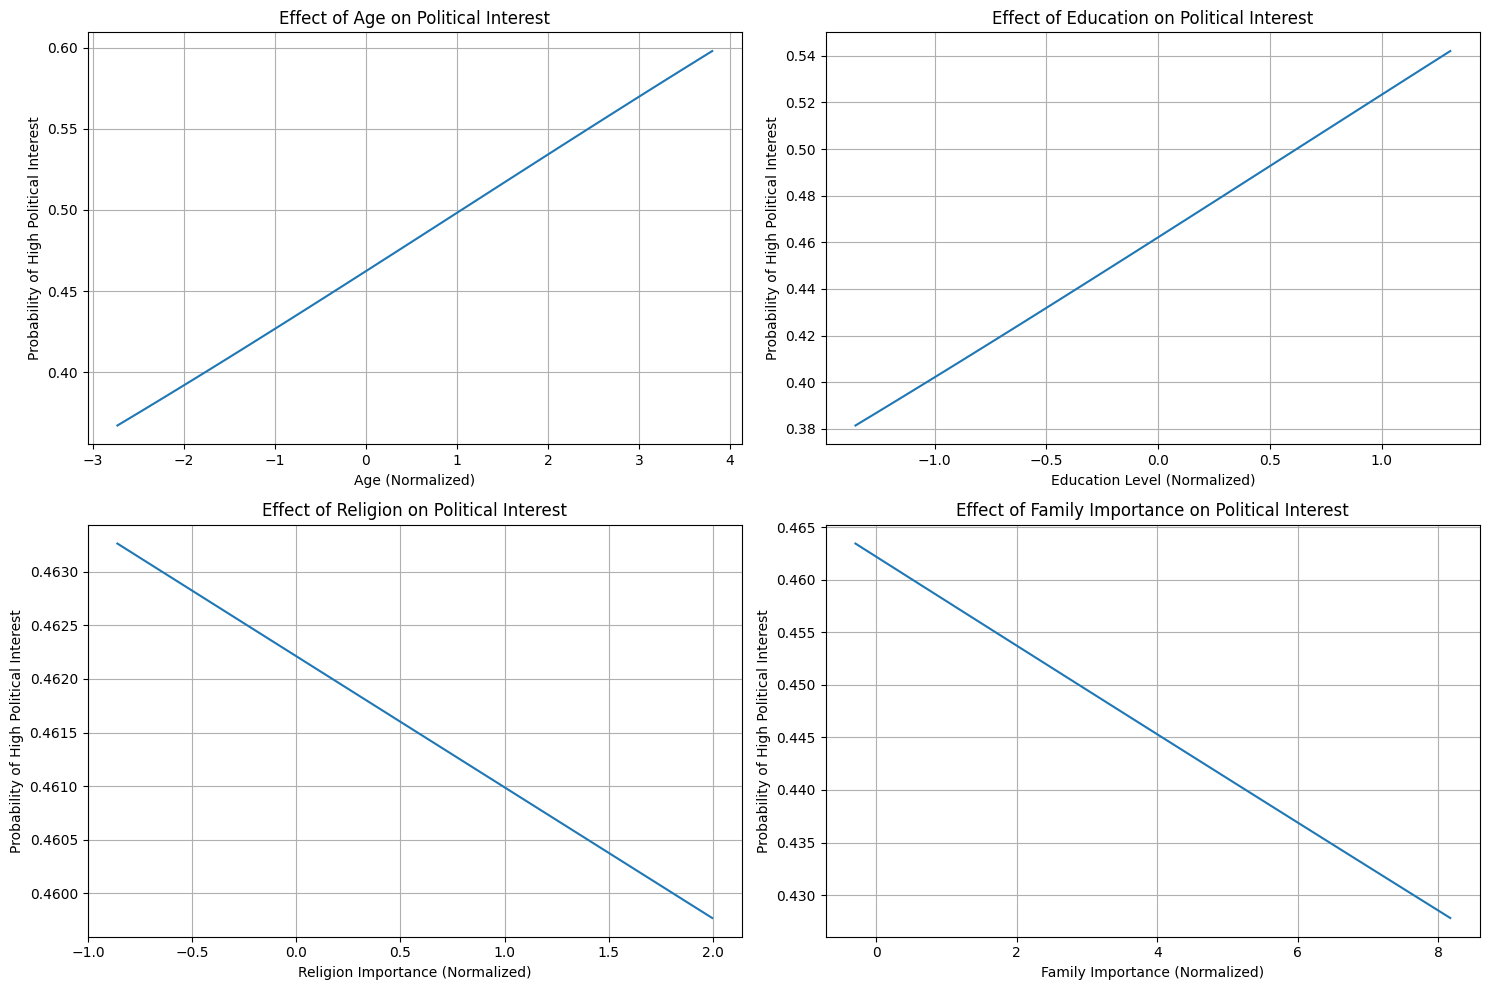

In [14]:
# Analyze model predictions by feature values
plt.figure(figsize=(15, 10))

# Plot probability of high political interest by age
plt.subplot(2, 2, 1)
# Create a 2D array with bias=1 and all features at their means except age
X_age = np.zeros((100, 5))
X_age[:, 0] = 1  # Bias
# Set other features to mean values
mean_values = np.mean(X_train, axis=0)
for i in range(3):  # For features other than age
    X_age[:, i+1] = mean_values[i]
# Vary age from min to max
age_range = np.linspace(np.min(X_train[:, 3]), np.max(X_train[:, 3]), 100)
X_age[:, 4] = age_range
probs_age = sigmoid(X_age @ theta)

plt.plot(age_range, probs_age)
plt.xlabel('Age (Normalized)')
plt.ylabel('Probability of High Political Interest')
plt.title('Effect of Age on Political Interest')
plt.grid(True)

# Plot probability of high political interest by education
plt.subplot(2, 2, 2)
X_edu = np.zeros((100, 5))
X_edu[:, 0] = 1  # Bias
for i in [0, 1, 3]:  # For features other than education
    idx = i if i < 2 else i-1
    X_edu[:, i+1] = mean_values[idx]
# Vary education from min to max
edu_range = np.linspace(np.min(X_train[:, 2]), np.max(X_train[:, 2]), 100)
X_edu[:, 3] = edu_range
probs_edu = sigmoid(X_edu @ theta)

plt.plot(edu_range, probs_edu)
plt.xlabel('Education Level (Normalized)')
plt.ylabel('Probability of High Political Interest')
plt.title('Effect of Education on Political Interest')
plt.grid(True)

# Plot probability by religion importance
plt.subplot(2, 2, 3)
X_rel = np.zeros((100, 5))
X_rel[:, 0] = 1  # Bias
for i in [1, 2, 3]:  # For features other than religion
    X_rel[:, i+1] = mean_values[i]
# Vary religion from min to max
rel_range = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), 100)
X_rel[:, 1] = rel_range
probs_rel = sigmoid(X_rel @ theta)

plt.plot(rel_range, probs_rel)
plt.xlabel('Religion Importance (Normalized)')
plt.ylabel('Probability of High Political Interest')
plt.title('Effect of Religion on Political Interest')
plt.grid(True)

# Plot probability by family importance
plt.subplot(2, 2, 4)
X_fam = np.zeros((100, 5))
X_fam[:, 0] = 1  # Bias
X_fam[:, 1] = mean_values[0]  # Religion
X_fam[:, 3] = mean_values[2]  # Education
X_fam[:, 4] = mean_values[3]  # Age
# Vary family from min to max
fam_range = np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), 100)
X_fam[:, 2] = fam_range
probs_fam = sigmoid(X_fam @ theta)

plt.plot(fam_range, probs_fam)
plt.xlabel('Family Importance (Normalized)')
plt.ylabel('Probability of High Political Interest')
plt.title('Effect of Family Importance on Political Interest')
plt.grid(True)

plt.tight_layout()
plt.savefig('feature_effects.png')
plt.show()

## Conclusion

In [15]:
# Conclusion
print("\nConclusion:")
print("Our model has been trained to predict political interest based on societal values and demographic factors.")
print(f"Model achieved {test_accuracy:.2%} accuracy on the test set.")
print("The most influential features (in order of importance) are:")
for i, row in coef_df.iterrows():
    if row['Feature'] != 'Bias':
        effect = "positive" if row['Coefficient'] > 0 else "negative"
        print(f"- {row['Feature']}: {effect} effect (coefficient = {row['Coefficient']:.4f})")

print("\nThese results suggest how societal values and demographics relate to political interest.")


Conclusion:
Our model has been trained to predict political interest based on societal values and demographic factors.
Model achieved 57.50% accuracy on the test set.
The most influential features (in order of importance) are:
- Education Level: positive effect (coefficient = 0.2452)
- Age: positive effect (coefficient = 0.1441)
- Family Importance: negative effect (coefficient = -0.0171)
- Religion Importance: negative effect (coefficient = -0.0049)

These results suggest how societal values and demographics relate to political interest.
